# Essentials Notebook
This notebook provides most important and must have tools for early stage analysis.
It allows to quickly verify reward function and identify potential problems.

Analysis is divided into 2 sections:
- Vehicle Behaviour
- Reward Properties

There are few code explanations, because it is assumed, that you have already visited *Training_analysis* notebook and have some knowledge about parameters described here. Non standard implementations are documented.

## Import modules

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from deepracer.tracks import TrackIO, Track
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    AnalysisUtils as au, \
    PlottingUtils as pu

## Load track

In [2]:
!ls tracks/

AmericasGeneratedInclStart.npy	New_York_Eval_Track.npy
AWS_track.npy			New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			reInvent2019_track.npy
Canada_Training.npy		reInvent2019_wide_mirrored.npy
China_eval_track.npy		reInvent2019_wide.npy
China_track.npy			reinvent_base.npy
FS_June2020.npy			Spain_track.npy
H_track.npy			Straight_track.npy
LGSWide.npy			Tokyo_Training_track.npy
London_Loop_Train.npy		Vegas_track.npy
Mexico_track_eval.npy		Virtual_May19_Train_track.npy
Mexico_track.npy


In [3]:
tu = TrackIO()

In [4]:
track = tu.load_track("reInvent2019_track")

Loaded 155 waypoints


In [5]:
def plot_track(t, fig=None):
    ratio = (lambda x,y: x / y)(*t.size())
    if fig is None:
        fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot()
    ax.axis('equal')
    ax.plot(*t.center_line.T, 'b')
    ax.plot(*t.outer_border.T, 'b')
    ax.plot(*t.inner_border.T, 'b')
    return ax

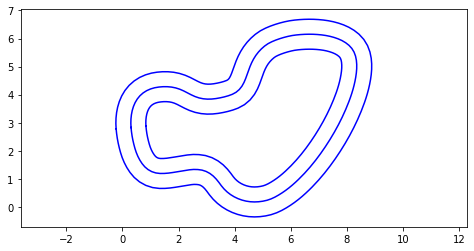

In [105]:
fig = plt.figure(figsize=(8,4))
ax = plot_track(track, fig)

In [106]:
def track_dheading(waypoints, N=2):
    """
    Calculate track waypoints heading in radians.
    N : waypoint look ahead
    """
    shifted = np.concatenate([waypoints[N:], waypoints[:N]])
    diff = shifted - waypoints
    t_heading = np.arctan2(diff.T[1], diff.T[0])
    dh = t_heading[1:] - t_heading[:-1]
    a = dh > math.pi
    b = dh < -math.pi
    dh[a] = dh[a] - 2*math.pi
    dh[b] = dh[b] + 2*math.pi
    return dh

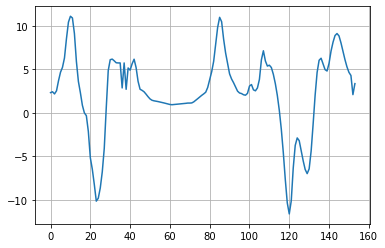

In [107]:
est_steering = np.degrees(track_dheading(track.center_line))
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

### Opposite direction
This code should be run to get estimated mean steering if trained with alternative direction parameter.

Such training runs agent in both directions changing heading every car reset.

In [21]:
inv_steering = np.array(list(reversed(est_steering)))
inv_steering *= -1
est_steering = (est_steering + inv_steering) / 2

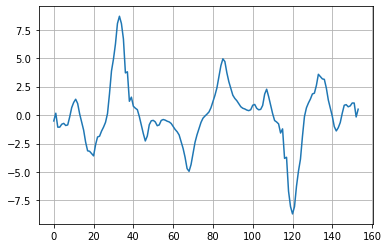

In [22]:
plt.plot(np.arange(len(est_steering)), est_steering)
plt.grid()

## Load log

In [108]:
stream_name = 'XTS-lambda' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path

In [109]:
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat

Log file exists, use force=True to download again


In [110]:
EPISODES_PER_ITERATION = 40 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])

In [111]:
df

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp
0,1,0,3,0.3298,2.5832,-85.3286,30.0,1.4,6.0,1.6863,0,True,1.0732,2,23.12,1592841351.329105
1,1,0,4,0.3312,2.5616,-85.5279,15.0,2.2,5.0,1.5680,0,True,1.1666,2,23.12,1592841351.4065363
2,1,0,5,0.3427,2.4554,-84.5327,15.0,2.2,5.0,1.8579,0,True,1.6259,2,23.12,1592841351.5108693
3,1,0,6,0.3530,2.3781,-83.5967,15.0,2.2,5.0,1.7547,0,True,1.9608,3,23.12,1592841351.5806897
4,1,0,7,0.3646,2.3074,-82.4078,15.0,2.2,5.0,1.7330,0,True,2.2682,3,23.12,1592841351.7117593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64203,23,919,166,0.4620,4.4867,-158.8179,30.0,1.4,6.0,0.0123,0,False,99.1153,145,23.12,1592850622.2846627
64204,23,919,167,0.3579,4.4140,-149.8893,30.0,1.4,6.0,0.0122,0,False,99.3384,145,23.12,1592850622.378185
64205,23,919,168,0.2760,4.3376,-142.1484,30.0,1.4,6.0,0.0135,0,False,99.7691,146,23.12,1592850622.469114
64206,23,919,169,0.2210,4.2726,-136.2788,30.0,1.4,6.0,0.0114,0,False,99.8370,146,23.12,1592850622.5590734


# Vehicle Behaviour
## Action distribution
More even the distribution is the better the action space is matched with the track. Also can detect not used actions.

In [112]:
df['action'].value_counts().sort_index()

0.0     6754
1.0    12138
2.0     7873
3.0     3727
4.0     2863
5.0    16090
6.0    14763
Name: action, dtype: int64

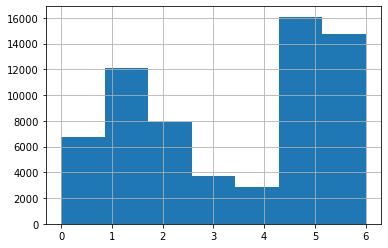

In [113]:
df['action'].hist(bins=int(df['action'].max() + 1))

-30.0     6754
-15.0    12138
-3.0      7873
 2.0      3727
 8.0      2863
 15.0    16090
 30.0    14763
Name: steer, dtype: int64

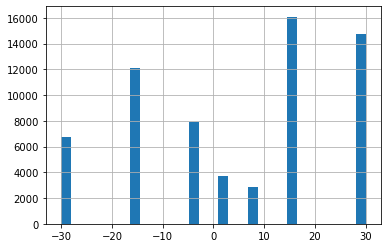

In [114]:
df['steer'].hist(bins=31)
df['steer'].value_counts().sort_index()

### Compare mean steering with estimate
Keep in mind that this is an estimatation of steering and not a perfect racing line solution. Your model should perform similarly to the estimated line but should be different from it as well if it correctly cuts corners or enters them.

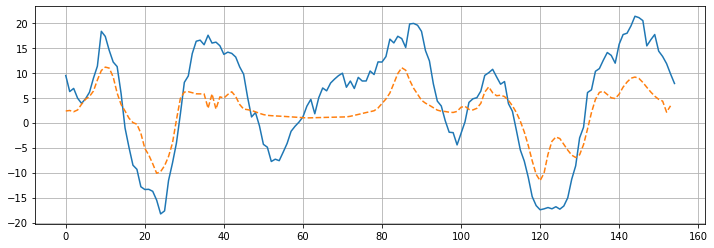

In [115]:
mean_steer = df[['steer', 'closest_waypoint']].groupby(by='closest_waypoint').mean()
plt.figure(figsize=(12,4))
plt.plot(mean_steer)
plt.plot(est_steering, '--')
plt.grid()

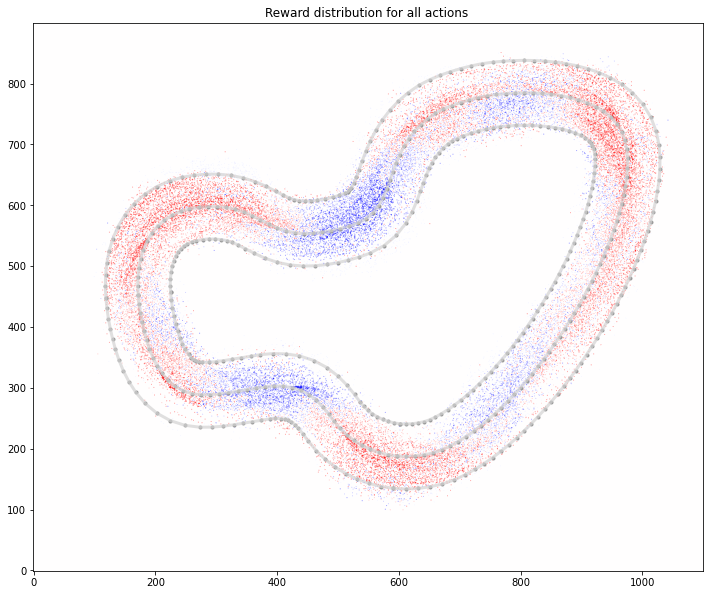

<Figure size 432x288 with 0 Axes>

In [116]:
pu.plot_track(df, track, value_field='steer', margin=1, cmap='bwr')

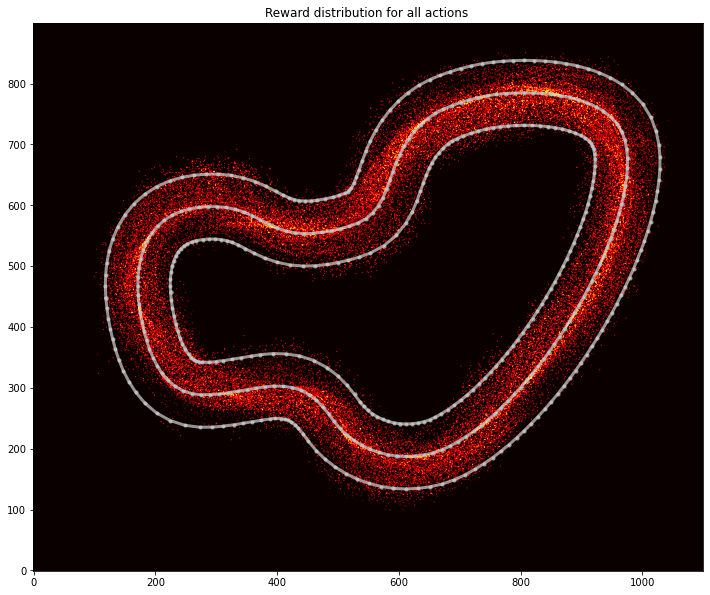

<Figure size 432x288 with 0 Axes>

In [117]:
pu.plot_track(df, track, value_field='throttle', margin=1)

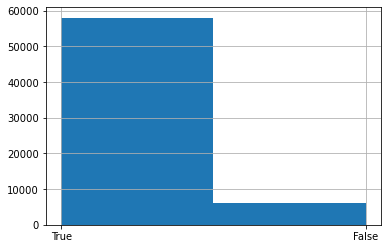

In [118]:
df['on_track'].hist(bins=2)

## Progress per steps
The higher the value the better.

In [119]:
pps = df['progress'].values / (1 + df['steps'].values)
df['pps'] = np.where(pps < 0.0, 0.0, pps)

In [120]:
sample = df[df['pps'] < 2.0]

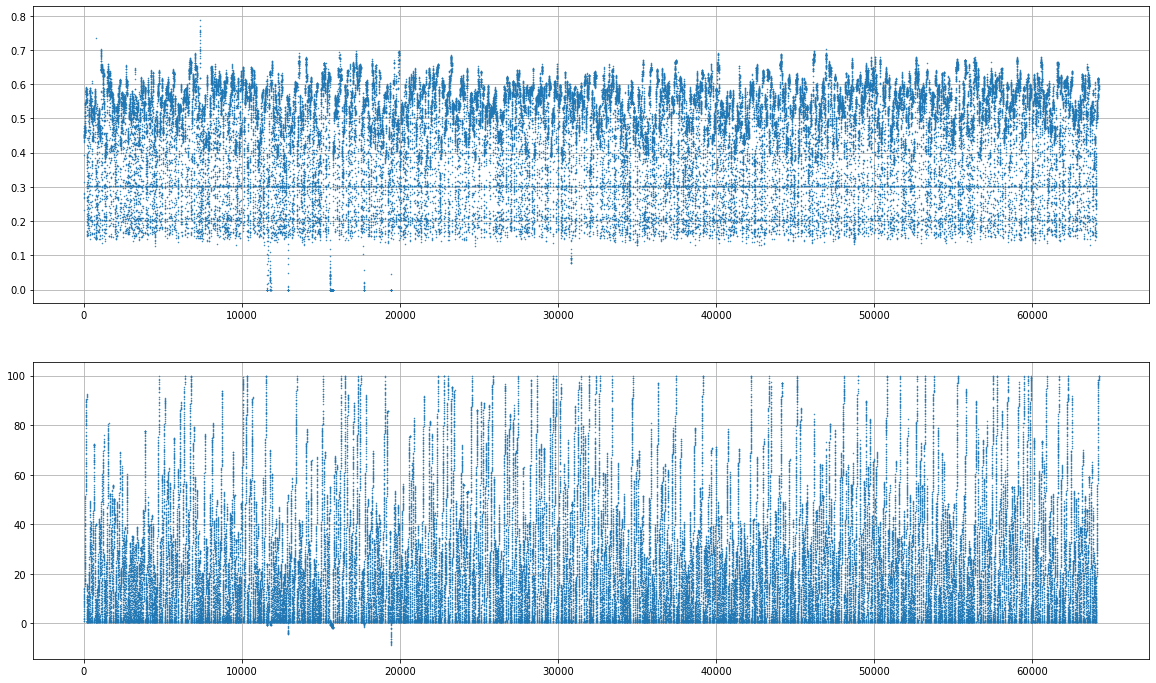

In [121]:
plt.figure(figsize=(20,12))
plt.subplot(211)
plt.plot(np.arange(0,len(sample)), sample['pps'], '.', markersize=1)
plt.grid()
plt.subplot(212)
plt.plot(np.arange(0,len(sample)), sample['progress'], '.', markersize=1)
plt.grid()

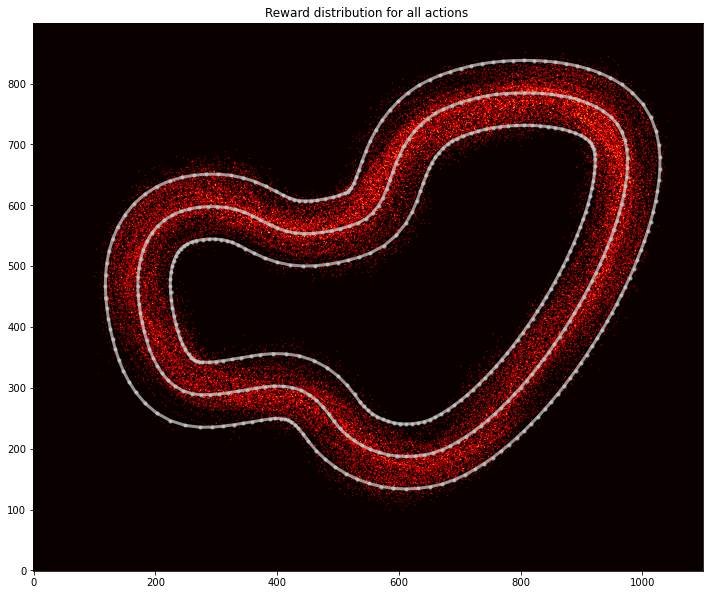

<Figure size 432x288 with 0 Axes>

In [122]:
pu.plot_track(sample, track, value_field='pps', margin=1)

In [123]:
df[['steps', 'progress']].corr()

,steps,progress
steps,1.000000,0.981329
progress,0.981329,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f754267ac40>,
      dtype=object)

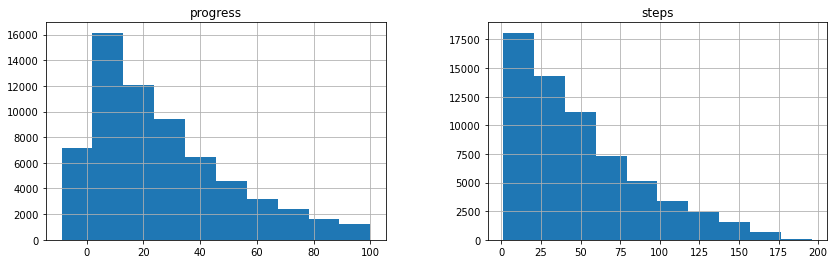

In [124]:
df[['steps', 'progress']].hist(figsize=(14,4))

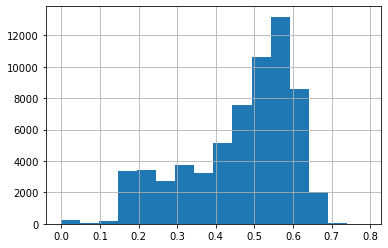

In [125]:
df['pps'].hist(bins=16)

## Progress and progress tempo
Tempo is the track distance covered in a single step.

> **NOTE** that it is calculated from progress so zig-zag does not count. We care only about distance covered towards the finish line.

The higher the value the better progress car is making.

In [126]:
def tempo(progress):
    result = np.zeros(len(progress))
    last = 0.0
    for x in range(0,len(progress)):
        d = 0.0
        p = progress[x] / 100.0
        if last < p:
            d = p - last
        result[x] = d
        last = max(float(p), 0.0)
    return result

In [127]:
# Logarithmic progress for increased contrast (subject to change if a better method of contrast increase is developed)
df['log_progress'] = [math.log(1.0 + max(r['progress'],0.0) / 10.0) for _,r in df.iterrows()]

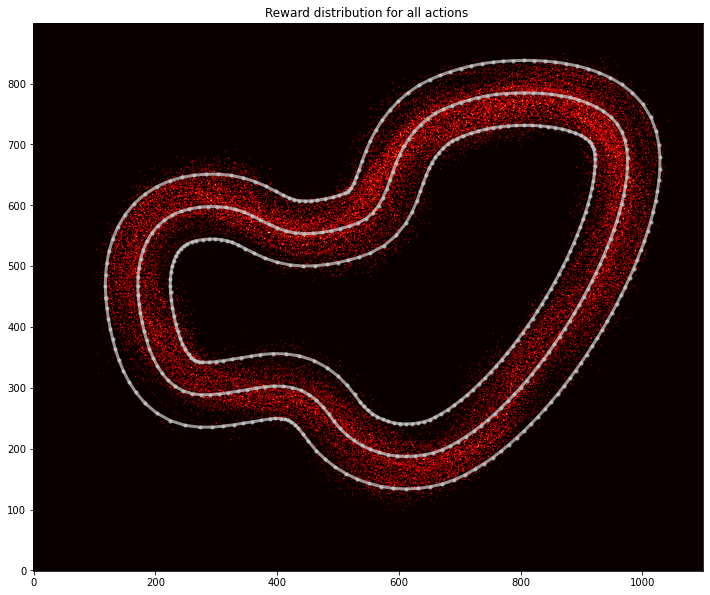

<Figure size 432x288 with 0 Axes>

In [128]:
pu.plot_track(df, track, value_field='log_progress', margin=1)

In [129]:
df['tempo'] = tempo(df['progress']) * df['track_len'][0]

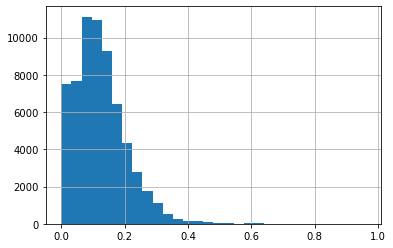

In [130]:
df['tempo'].hist(bins=30)

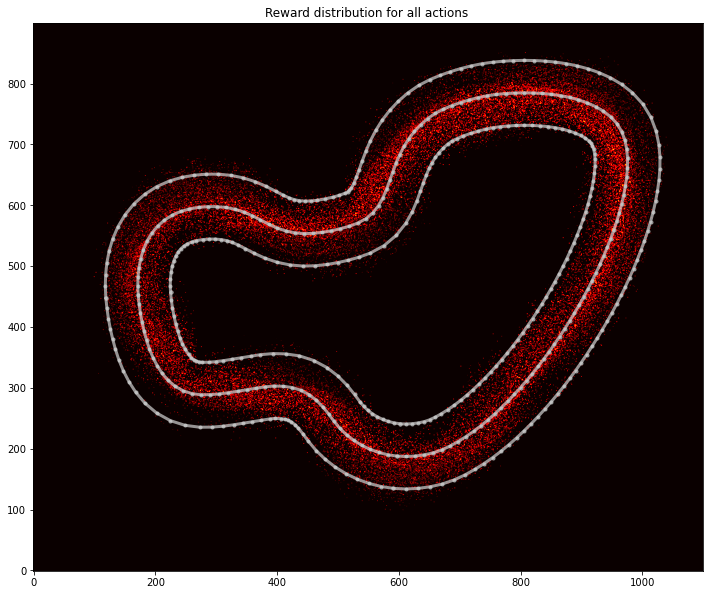

<Figure size 432x288 with 0 Axes>

In [131]:
pu.plot_track(df[df['tempo'] < 0.25], track, value_field='tempo')

# Training Metrics
Plot metrics with a console like plot.

> Keep in mind that there are no logs from evaluation runs, so you cannot see them here like you do inside AWS Console. Training episode progress is usually much worse because of the entropy that puts the car in unexcpected states.

In [132]:
metrics = df[['iteration','episode','reward','tempo']].copy()
metrics = metrics.groupby(by=['iteration','episode']).sum()
metrics.loc[:,'tempo'] = metrics.loc[:,'tempo'].values * 100 / df['track_len'][0]
iter_metrics = metrics[['reward','tempo']].groupby(by='iteration').mean()

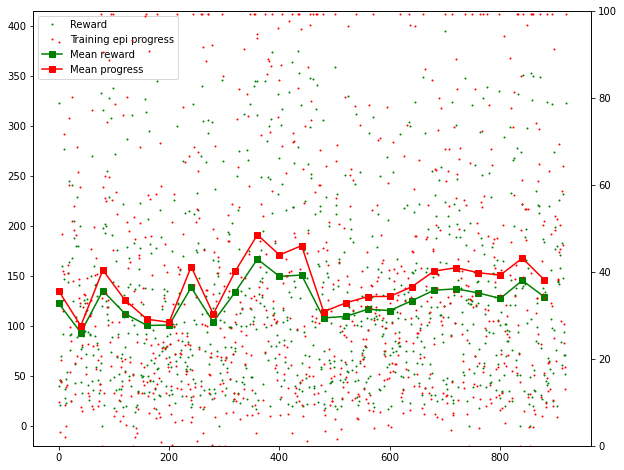

In [133]:
epi = np.arange(len(metrics))
it = np.arange(epi.min(), epi.max(), EPISODES_PER_ITERATION)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
axp = ax.twinx()
axp.set_ylim((0,100))
d1 = ax.plot(epi, metrics['reward'].values, 'g.', markersize=2)
d2 = axp.plot(epi, metrics['tempo'].values, 'r.', markersize=2)
d3 = ax.plot(it, iter_metrics['reward'].values, 'g-s')
d4 = axp.plot(it, iter_metrics['tempo'].values, 'r-s')
data = d1 + d2 + d3 + d4
ax.legend(data, ['Reward', 'Training epi progress', 'Mean reward', 'Mean progress'])

# Reward Properties
Analyze returned reward, apply different rewards for comparison.

## Helper definitions

In [134]:
def df2params(frame, track: Track, mapping=None):
    if mapping is None:
        mapping = {'on_track':'all_wheels_on_track', 'throttle':'speed',
                   'yaw':'heading', 'steer':'steering_angle', 'track_len':'track_length', 'progress':'progress', 'steps':'steps',
                  'x':'x', 'y':'y', 'distance_from_center':'distance_from_center'}
    d = {'closest_waypoints': [frame['closest_waypoint'], (frame['closest_waypoint']+1)%len(track.center_line)]}
    width = np.linalg.norm(track.inner_border[0] - track.outer_border[0])
    d.update({'is_reversed':False, 'waypoints':track.center_line, 'track_width':width})
    d.update({mapping[k]:frame[k] for k in mapping})
    return d

In [135]:
import importlib

### Estimate missing parameters

In [136]:
def dist_from_center(row, waypoints):
    "Adds missing distance_from_center column"
    close = row['closest_waypoint']
    estimated = np.array(waypoints[close])
    pos = np.array([row['x'], row['y']])
    dist = np.linalg.norm(pos - estimated)
    return dist

In [137]:
df['distance_from_center'] = [dist_from_center(r, track.center_line) for _,r in df.iterrows()]

## Apply different reward

In [138]:
name = 'adversarial'
reward = importlib.import_module('rewards.{0}'.format(name))
# Reload module so it is always up to date
importlib.reload(reward)
reward_function = reward.reward_function

In [139]:
original = 'reward'
# Recalculate log can be unncessary because we use original value from memory
if 'log_'+original not in df.columns:
    df['log_' + original] = [math.log(1 + r[original]) for _,r in df.iterrows()]

In [140]:
df[name] = [reward_function(df2params(r, track)) for _,r in df.iterrows()]
df['log_' + name] = [math.log(1 + r[name]) for _,r in df.iterrows()]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f754b28e8e0>,
      dtype=object)

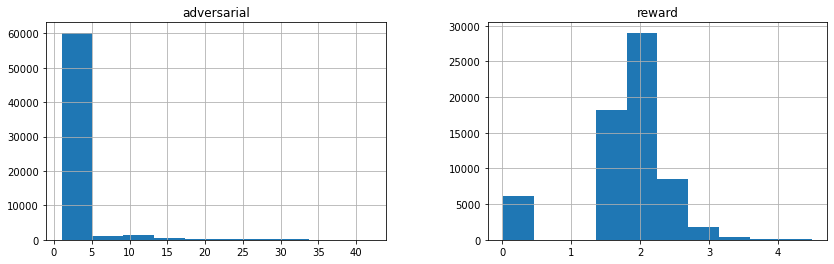

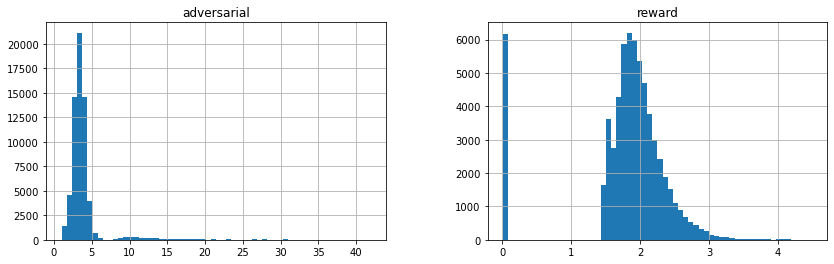

In [141]:
df[[original, name]].hist(figsize=(14,4))
df[[original, name]].hist(figsize=(14,4), bins=60)

In [142]:
df[[original, name]].describe()

,reward,adversarial
count,64208.000000,64208.000000
mean,1.802338,3.953810
std,0.669972,3.232804
min,0.010000,0.996847
25%,1.690100,2.870461
50%,1.897400,3.432642
75%,2.131500,3.954931
max,4.493400,41.878330


Text(0.5, 1.0, 'adversarial')

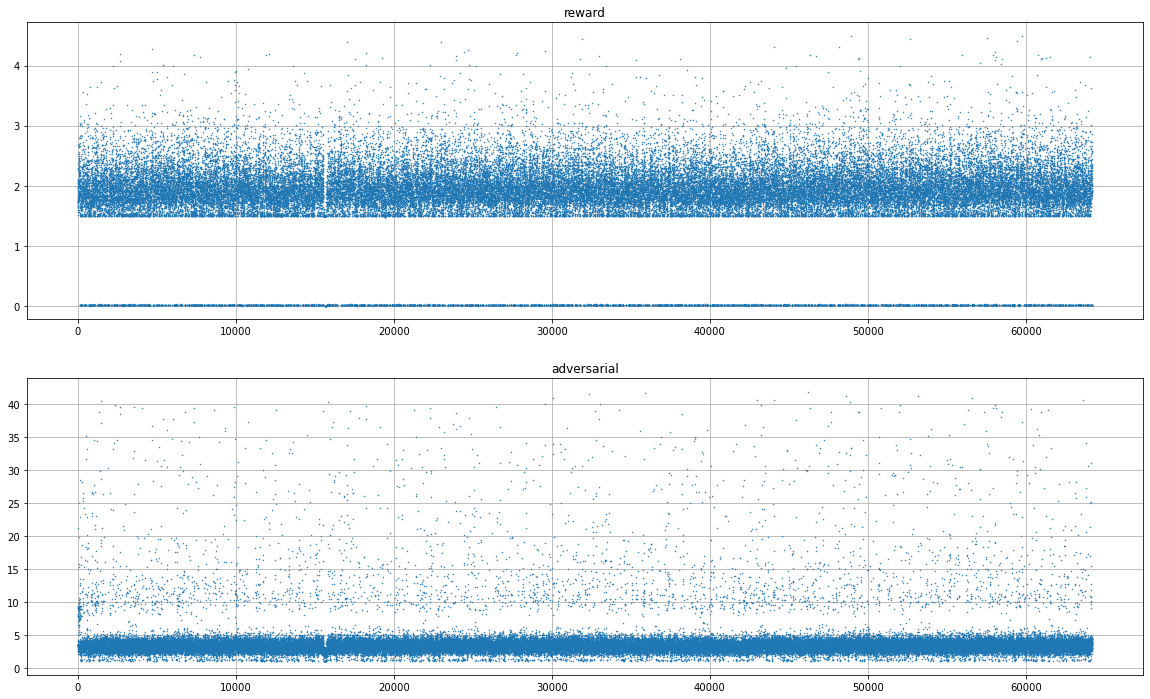

In [143]:
plt.figure(figsize=(20,12))

plt.subplot(2,1,1)
plt.plot(df.index, df[original], '.', markersize=1)
plt.grid()
plt.title(original)

plt.subplot(2,1,2)
plt.plot(df.index, df[name], '.', markersize=1)
plt.grid()
plt.title(name)

In [144]:
sample = df.sample(frac=0.75)
#sample = df[df[name] < 8]

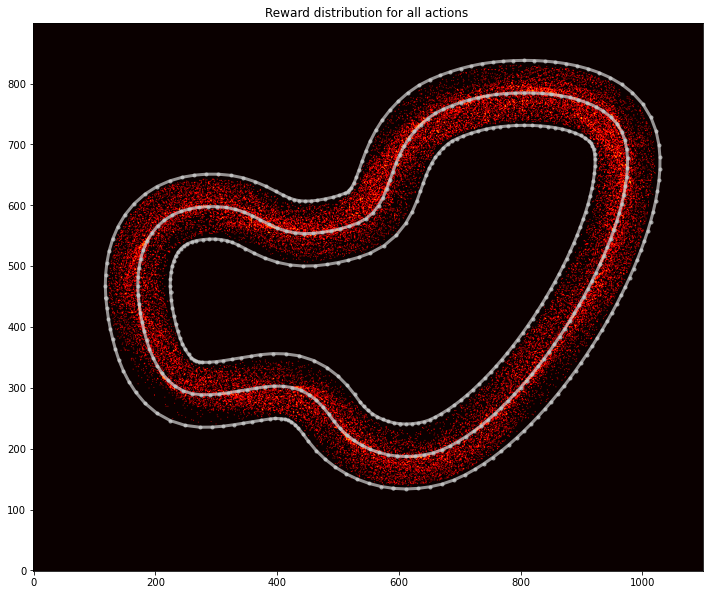

<Figure size 432x288 with 0 Axes>

In [145]:
pu.plot_track(sample, track, value_field='log_{0}'.format(original))

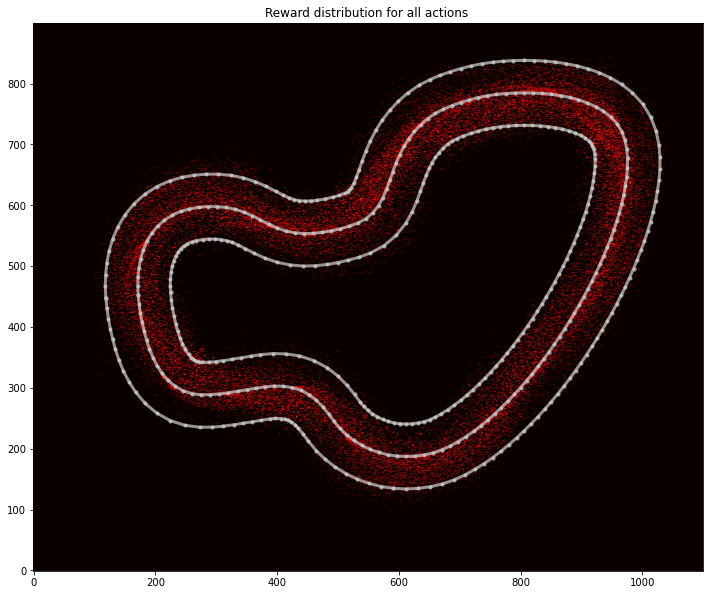

<Figure size 432x288 with 0 Axes>

In [146]:
pu.plot_track(sample, track, value_field='log_{0}'.format(name))

## Plot saved sectors
If your last computed reward function implements sectors global variable storing model records, you can plot it here.

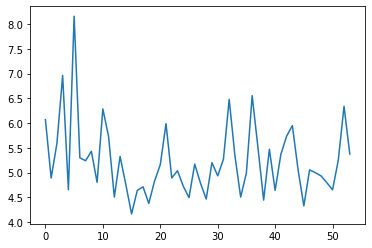

In [147]:
sectors = pd.DataFrame([(a[0],a[1],b) for a,b in reward.sectors.items()], columns=['x', 'y', 'var'])
plt.plot(sectors.index, sectors['var'])

# Top explored solutions
Verify what your model has found to give the best results.

In [148]:
best_epi = df.groupby('episode').sum().nlargest(100, 'reward')
best_epi['steps'] = (np.sqrt(1 + best_epi['steps'].values * 8) - 1) / 2
best_epi['time'] = best_epi['steps'].values / 15
best_epi[['reward',name,'pps','tempo','distance_from_center', 'steps', 'time']].head()

,reward,adversarial,pps,tempo,distance_from_center,steps,time
episode,,,,,,,
700,395.2863,825.360480,97.625515,22.978714,35.715855,196.0,13.066667
434,375.3578,795.478966,87.220779,22.979870,47.609899,195.0,13.000000
386,374.2990,714.012513,94.608428,22.980008,35.700826,193.0,12.866667
423,363.6215,660.904186,87.281716,22.980610,30.908714,176.0,11.733333
501,358.9492,802.483236,96.407008,22.980286,39.126007,182.0,12.133333


In [149]:
best_epi_index = np.vectorize(lambda x: x in best_epi.index.values)(df['episode'].values)
best_epi = df[best_epi_index]
best_epi.head()

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,...,closest_waypoint,track_len,timestamp,pps,log_progress,tempo,distance_from_center,log_reward,adversarial,log_adversarial
0,1,0,3,0.3298,2.5832,-85.3286,30.0,1.4,6.0,1.6863,...,2,23.12,1592841351.329105,0.268300,0.101943,0.248124,0.054608,0.988165,6.577240,2.025149
1,1,0,4,0.3312,2.5616,-85.5279,15.0,2.2,5.0,1.5680,...,2,23.12,1592841351.4065363,0.233320,0.110342,0.021594,0.033791,0.943127,2.474002,1.245307
2,1,0,5,0.3427,2.4554,-84.5327,15.0,2.2,5.0,1.8579,...,2,23.12,1592841351.5108693,0.270983,0.150650,0.106190,0.075374,1.050087,9.416353,2.343377
3,1,0,6,0.3530,2.3781,-83.5967,15.0,2.2,5.0,1.7547,...,3,23.12,1592841351.5806897,0.280114,0.179050,0.077429,0.020348,1.013309,3.509350,1.506153
4,1,0,7,0.3646,2.3074,-82.4078,15.0,2.2,5.0,1.7330,...,3,23.12,1592841351.7117593,0.283525,0.204425,0.071071,0.075310,1.005400,3.466073,1.496509


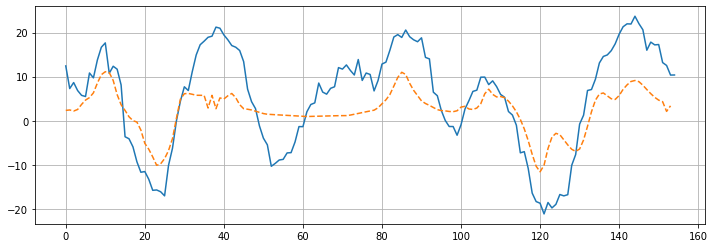

In [150]:
mean_steer = best_epi[['steer', 'closest_waypoint']].groupby(by='closest_waypoint').mean()
plt.figure(figsize=(12,4))
plt.plot(mean_steer)
plt.plot(est_steering, '--')
plt.grid()

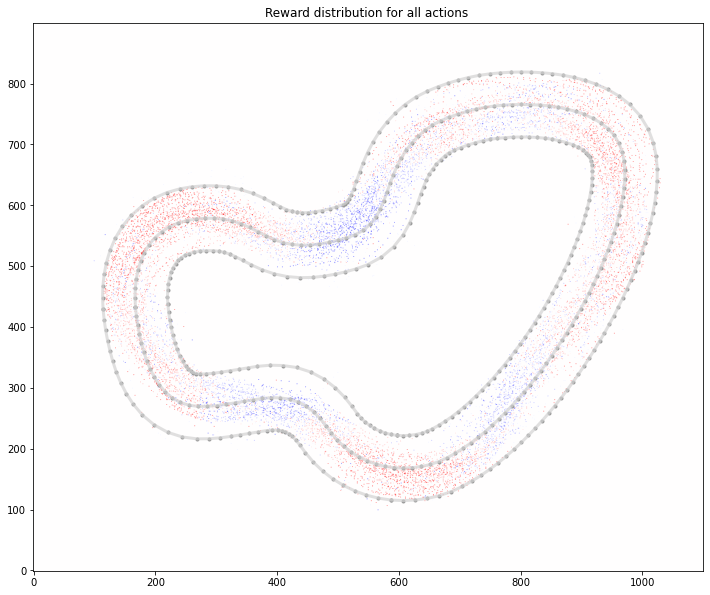

<Figure size 432x288 with 0 Axes>

In [151]:
pu.plot_track(best_epi, track, value_field='steer', margin=1, cmap='bwr')

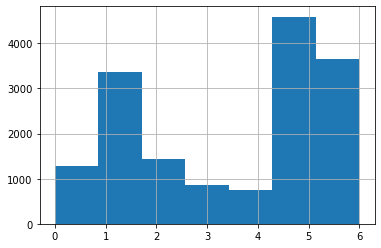

In [152]:
best_epi['action'].hist(bins=int(df['action'].max() + 1))

-30.0    1272
-15.0    3354
-3.0     1444
 2.0      850
 8.0      749
 15.0    4589
 30.0    3659
Name: steer, dtype: int64

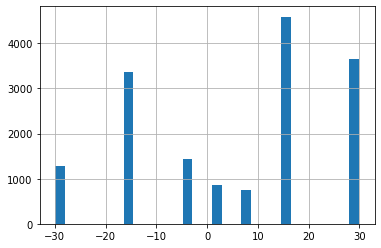

In [153]:
best_epi['steer'].hist(bins=31)
best_epi['steer'].value_counts().sort_index()

In [154]:
best_waypoint = best_epi.groupby('closest_waypoint').mean()

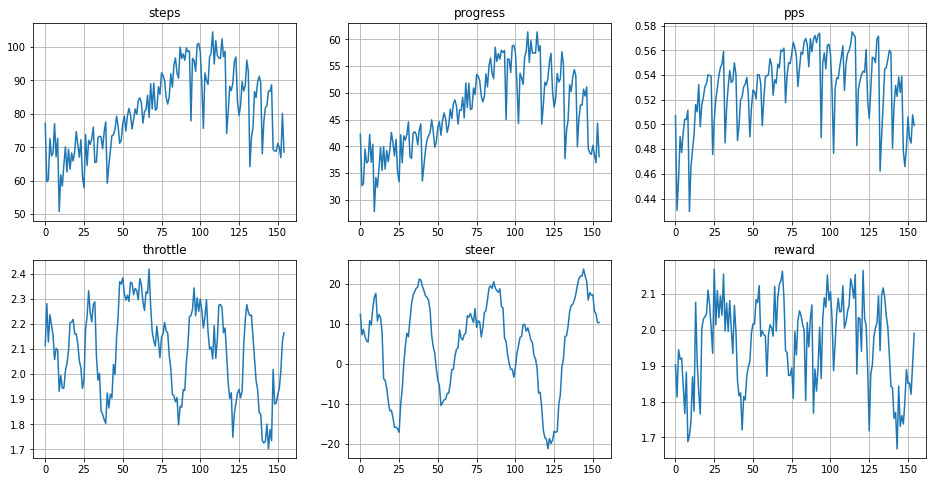

In [155]:
subplots = [(231,'steps'), (232,'progress'), (233,'pps'), (234,'throttle'), (235,'steer'), (236,'reward')]
plt.figure(figsize=(16,8))
for s in subplots:
    plt.subplot(s[0])
    plt.plot(best_waypoint[s[1]])
    plt.title(s[1])
    plt.grid()

### Reoptimize action space
Try to replace current actions with a better solution. Uses k-means clustering to solve this problem.

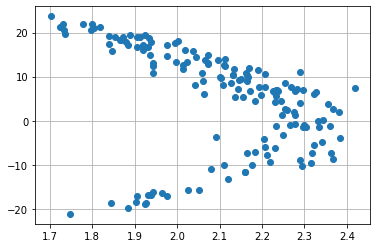

In [156]:
actions = best_waypoint[['throttle','steer']].values
plt.plot(*actions.T, 'o')
plt.grid()

In [157]:
from sklearn.cluster import KMeans

In [158]:
N_OF_ACTIONS = 7
km = KMeans(n_clusters=N_OF_ACTIONS).fit(actions)
centers = km.cluster_centers_

In [210]:
new_actions = pd.DataFrame(centers, columns=['throttle','steer']).sort_values(['steer','throttle']).reset_index(drop=True)

In [211]:
a = new_actions['throttle'].values
new_actions['throttle'] = np.interp(a, (a.min(), a.max()), (1.6, 3.2))

In [212]:
new_actions

,throttle,steer
0,1.995621,-17.394960
1,3.027373,-8.459577
2,3.200000,-0.472990
3,2.977516,6.484629
4,2.548747,11.215670
5,2.098965,16.155666
6,1.600000,20.192128


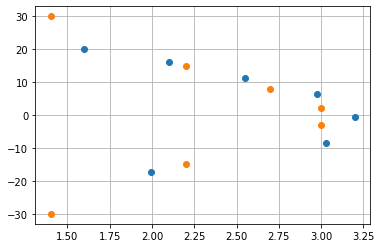

In [214]:
plt.plot(*new_actions.values.T, 'o')
plt.plot(*np.unique(best_epi[['throttle','steer']].values, axis=0).T, 'o')
plt.grid()

# Bonus: Analyze reward distribution

Here we create heatmaps with reward distribution along 2 parameters of choice.

In [178]:
def plot3d_reward(x, y, rewardf):
    "Plot rewardf(x,y) reward to visualize reward resoponse on x,y parameters change"
    X,Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    # ideally array should be passed into the reward, but some rewards use functions from math library,
    # which is incompatible with numpy arrays
    # to solve this problem we calculate reward iteratively
    for r in range(0,Z.shape[0]):
        for c in range(0,Z.shape[1]):
            Z[r,c] = rewardf(X[r,c], Y[r,c])
    sns.heatmap(Z)

In [179]:
def updated_params(params, **kwargs):
    p = dict(params)
    p.update(kwargs)
    return p

In [180]:
src = df.sample(n=1)
src

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,...,closest_waypoint,track_len,timestamp,pps,log_progress,tempo,distance_from_center,log_reward,adversarial,log_adversarial
13026,6,178,73,5.5286,0.0481,27.3687,-3.0,2.7,2.0,1.9453,...,45,23.12,1592766394.2307267,0.521253,1.580477,0.110699,0.318405,1.080211,2.334404,1.204294


In [181]:
params = df2params(src.iloc[0], track)
rew = lambda x, y: reward_function(updated_params(params, distance_from_center=x, heading=y))

In [183]:
X = np.linspace(0.0, params['track_width'], num=100)
Y = np.linspace(-180, 180, num=100)

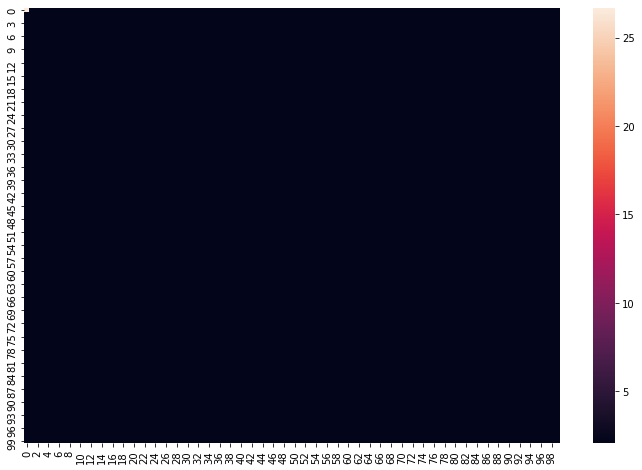

In [184]:
fig = plt.figure(figsize=(12,8))
plot3d_reward(X, Y, rew)

## Helper: Compare functions
Choose your warrior wisely. Your function needs improvement? Incorrect distribution? Don't worry! Let's see which function does suit your needs best!

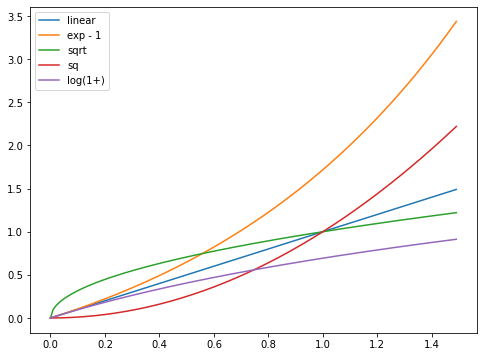

In [72]:
ox = np.arange(0,1.5,0.01)
plt.figure(figsize=(8,6))
plt.plot(ox, ox)
plt.plot(ox, np.exp(ox) - 1)
plt.plot(ox, np.sqrt(ox))
plt.plot(ox, np.power(ox, 2.0))
plt.plot(ox, np.log(1 + ox))
plt.legend(['linear','exp - 1','sqrt','sq','log(1+)'])